# Install Libraries

In [186]:
%pip install numpy
%pip install pandas
%pip install openpyxl
%pip install matplotlib
%pip install statsmodels
%pip install sklearn
%pip install prophet

Python(51274) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Python(51277) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Python(51280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Python(51283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Python(51286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Python(51289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a

Python(51296) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [187]:
import os
import argparse
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

# Input Arguments

In [192]:
EXCEL_FILE_PATH = 'CBO Revenue Short.xlsx'
OUTPUT_FILE_PATH = 'TruCast Output 3 Month.xlsx'
MEDIUM_THRESHOLD = 200000 # in dollars
LARGE_THRESHOLD = 533000 # in dollars
NUMBER_OF_MONTHS = 12 # in months

# Functions

In [193]:
def fixed(revenue_series):
    return [revenue_series.iloc[-1]]*NUMBER_OF_MONTHS

def three_month(revenue_series):
    return [(revenue_series.iloc[-3] + revenue_series.iloc[-2] + revenue_series.iloc[-1])/3]*NUMBER_OF_MONTHS


def ARIMA_rolling_forcast_origin(revenue_series, number_of_predicted_months, p, q, d):
    # Preforms a rolling forcast origin for an using an arima model on times series data for a set number of number_of_predicted_months < len(revenue_series) 
    arima_revenue_projection_list = revenue_series.tolist()
    total_revenue_by_month_list = revenue_series.tolist()
    for index, revenue in enumerate(arima_revenue_projection_list):
        if len(arima_revenue_projection_list) - index < number_of_predicted_months:
            try:
                model = ARIMA(total_revenue_by_month_list[0:index], order=(p, d, q))
                try:
                    results = model.fit()
                    forecast = results.forecast(steps=1)
                except LinAlgError as e:
                    forecast = [-10000000]
                arima_revenue_projection_list[index] = forecast[0]
            except LinAlgError as e:
                arima_revenue_projection_list[index] = np.nan
                continue
    arima_revenue_projection = pd.Series(data=arima_revenue_projection_list, index=revenue_series.index)
    
    return arima_revenue_projection

def arima(revenue_series):
    # Train on 1/3 of the data
    number_of_predicted_months = int(len(revenue_series)/3)

    # Choose the range of p and q that you want to optmize over
    p_range = 6
    q_range = 6
    d = 1

    # Create an ARIMA model on the data for each value of p and q forcast it forward using a rolling origin forcast, determine which pair of p and q works
    # best and output that
    arima_revenue_projection_list = revenue_series.tolist()
    projection_percent_difference = {}
    for i in range(1, p_range):
        for ii in range(1, q_range):
            projection = ARIMA_rolling_forcast_origin(revenue_series, number_of_predicted_months, i, ii, d)

            percent_difference = abs(projection[-number_of_predicted_months:] - arima_revenue_projection_list[-number_of_predicted_months:]) / arima_revenue_projection_list[-number_of_predicted_months:] * 100
            projection_avg_percent_difference = percent_difference.mean()

            if projection_avg_percent_difference == np.nan:
                # If any errors occur set the percent error to really high so it doesn't get choosen
                projection_percent_difference[(i, ii)] = 1000
            else:
                projection_percent_difference[(i, ii)] = projection_avg_percent_difference

    min_error_key = min(projection_percent_difference, key=projection_percent_difference.get)
    p = min_error_key[0]
    q = min_error_key[1]

    # Use the ARIMA model that produced the minimum error and forcast 1 time step forward
    model = ARIMA(revenue_series, order=(p, d, q))
    results = model.fit()
    forecast = results.forecast(steps=NUMBER_OF_MONTHS)

    return forecast

def prophet(revenue_series):
    # for the model, make a dataframe with columns 'ds' and 'y' out of the hospital row, which was a Series
    curr_hospital = pd.DataFrame({'ds':revenue_series.index, 'y':revenue_series.values})

    # make the months datetime objects, and the revenues numbers
    curr_hospital['ds'] = pd.to_datetime(curr_hospital['ds'])
    curr_hospital['y'] = pd.to_numeric(curr_hospital['y'])

    # training on all revenues up to the last year (CAN BE MODIFIED TO BE THE LAST MONTH, TWO MONTHS, ETC.)
    # MUDIT COMMENT: JUST GOT RID OF THE "-NUMBER_OF_MONTHS" HERE, NOW TRAINING ON ALL DATA IN REVENUE_SERIES
    train = curr_hospital.iloc[:len(curr_hospital)]

    # testing how accurately we predict the last year (CAN BE MODIFIED TO BE THE LAST MONTH, TWO MONTHS, ETC.)
    test = curr_hospital.iloc[len(curr_hospital) - NUMBER_OF_MONTHS:]

    # if this row of the dataframe contains less than two non-nan values, we cannot predict on it — SKIP
    if train[train['y'].notnull()].shape[0] < 2:
        return None # WE SHOULD REDIRECT HERE TO ANOTHER MODEL, IF THERE IS NOT ENOUGH TRAINING DATA FOR PROPHET
    
    # fit the model, generate the forecast
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods = NUMBER_OF_MONTHS, freq='MS')
    forecast = m.predict(future)

    # generate predictions (contains all from 2004 through 2023)
    predictions = forecast[['ds', 'yhat']].set_index('ds')['yhat'].iloc[-NUMBER_OF_MONTHS:]
    predictions_lower = forecast[['ds', 'yhat_lower']].set_index('ds')['yhat_lower'].iloc[-NUMBER_OF_MONTHS:]
    predictions_upper = forecast[['ds', 'yhat_upper']].set_index('ds')['yhat_upper'].iloc[-NUMBER_OF_MONTHS:]
    
    output_columns = predictions.index

    # return a tuple of the lower, point estimate, and upper bound for the last month
    return (predictions.values, predictions_lower.values, predictions_upper.values)

def determine_projection(revenue_series, medium_threshold, large_threshold, fixed_rate_projection, three_month_projection, arima_projection, prophet_projection):
    # if it's fixed, return fixed rate
    if (fixed_rate_projection != -1):
        return fixed_rate_projection
    
    if revenue_series.iloc[-NUMBER_OF_MONTHS:].count() == NUMBER_OF_MONTHS:
        yearly_revenue = sum(revenue_series.iloc[-NUMBER_OF_MONTHS:])
    else:
        yearly_revenue = (revenue_series.mean())*NUMBER_OF_MONTHS
    
    if yearly_revenue < medium_threshold:
        return arima_projection
    else:
        return prophet_projection
    
def determine_projection_type(revenue_series, medium_threshold, large_threshold):
    if (revenue_series.iloc[-2] == revenue_series.iloc[-1]) or (np.isnan(revenue_series.iloc[-1])):
        return 'fixed'
    elif revenue_series.iloc[-NUMBER_OF_MONTHS:].count() == NUMBER_OF_MONTHS:
        yearly_revenue = sum(revenue_series.iloc[-NUMBER_OF_MONTHS:])
    else:
        # if there isn't a years worth of data just return a 3 month average
        return 'three_month'
    
    if yearly_revenue < medium_threshold:
        return 'arima'
    else:
        return 'prophet'
    
def rename_duplicates(names):
    name_count = {}
    modified_names = []

    for name in names:
        if name in name_count:
            name_count[name] += 1
        else:
            name_count[name] = 1

        if name_count[name] == 1:
            modified_names.append(name)
        else:
            modified_names.append(f"{name}_{name_count[name]-1}")

    return modified_names
    


# TruCast

In [166]:
if EXCEL_FILE_PATH.endswith('.xls') or EXCEL_FILE_PATH.endswith('.xlsx'):
    #revenue_data = pd.read_excel(EXCEL_FILE_PATH, index_col=['Site', 'Customer Code'])
    revenue_data = pd.read_excel(EXCEL_FILE_PATH, index_col='site')
else:
    print("Error: Input file must be in Excel format.")

# TODO Clean data


# Create dataframe for the output date
new_months = list(pd.date_range(revenue_data.columns[-1], periods=13, freq='M').strftime('%Y-%m'))[1:13]
revenue_data.columns = [col.strftime('%Y-%m') if isinstance(col, pd.Timestamp) else col for col in revenue_data.columns]
column_names = list(revenue_data.columns) + new_months
revenue_data.index = rename_duplicates(revenue_data.index)
output_data = pd.DataFrame(index=revenue_data.index, columns=column_names)

#Loop through hospitals
for hospital, revenue_series in revenue_data.iterrows():
    projection_type = determine_projection_type(revenue_series, MEDIUM_THRESHOLD, LARGE_THRESHOLD)
    print(f'{hospital}: {projection_type}')
    if projection_type == 'fixed':
        projection = fixed(revenue_series)
    elif projection_type == 'three_month':
        projection = three_month(revenue_series)
    elif projection_type == 'arima':
        projection = arima(revenue_series)
        #projection = [0]*12
    elif projection_type == 'prophet':
        (projection, prophet_low, prophet_high) = prophet(revenue_series)

    projection = [rev if rev >= 0 or np.isnan(rev) else 0 for rev in projection] # Sets a lower bound of 0 for any projection

    output_data.loc[hospital] = pd.concat([revenue_series, pd.Series(data=projection, index=new_months)])

output_data.dropna(inplace=True, how='all')
output_data.to_excel(OUTPUT_FILE_PATH, index_label='site')
display(output_data)

/var/folders/cv/y2tvyddn08q5b2tl07vby8fc0000gn/T/ipykernel_72405/2477112787.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  new_months = list(pd.date_range(revenue_data.columns[-1], periods=13, freq='M').strftime('%Y-%m'))[1:13]
16:52:03 - cmdstanpy - INFO - Chain [1] start processing
Python(98747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:03 - cmdstanpy - INFO - Chain [1] done processing


Abraham Lincoln: fixed
Acadia-St.Landry Hospital: prophet


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Adirondack Medical Center: fixed
Alaska Native Tribal Health: three_month
Aleutian Pribilof Islands Association: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver

Allen Parish: prophet
American Behavioral Health Systems, Inc.: prophet
Arbuckle Memorial: fixed
Arizona General: fixed
Artesia General: prophet


Python(98757) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:19 - cmdstanpy - INFO - Chain [1] done processing
16:52:19 - cmdstanpy - INFO - Chain [1] start processing
Python(98758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:19 - cmdstanpy - INFO - Chain [1] done processing
16:52:19 - cmdstanpy - INFO - Chain [1] start processing
Python(98759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Atchison Clinic: fixed
Atchison Hospital: prophet
BAYSIDE COMMUNITY CLINIC: prophet


16:52:19 - cmdstanpy - INFO - Chain [1] done processing
16:52:19 - cmdstanpy - INFO - Chain [1] start processing
Python(98760) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:19 - cmdstanpy - INFO - Chain [1] done processing
16:52:19 - cmdstanpy - INFO - Chain [1] start processing
Python(98761) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


BAYSIDE COMMUNITY HOSPITAL: prophet
BEAR VALLEY COMMUNITY HEALTHCARE: prophet


16:52:19 - cmdstanpy - INFO - Chain [1] done processing
16:52:19 - cmdstanpy - INFO - Chain [1] start processing
Python(98762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:19 - cmdstanpy - INFO - Chain [1] done processing
16:52:19 - cmdstanpy - INFO - Chain [1] start processing
Python(98763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:20 - cmdstanpy - INFO - Chain [1] done processing


Barlow Respiratory Hospital: fixed
Bath Community Hospital: prophet
Big Sandy Medical Center: fixed
Big South Fork Medical Center: three_month
Black Hills Surgical: fixed
Boone Memorial: prophet
Bristow (CMOS): fixed
Brodstone: fixed
Brodstone Medicaid: fixed
Brownfield Regional: three_month
Buchanan Clinic: fixed
Buchanan General: prophet


16:52:20 - cmdstanpy - INFO - Chain [1] start processing
Python(98764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:20 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Buchanan Surgical Clinic: fixed
Buchanan Tri-State Clinic: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Burke Hospital: prophet
CHC Community Care: prophet
Caldwell: fixed
Caldwell - ARMS Clinic: fixed
Caldwell - IFS: fixed
Calhoun Liberty Hospital: prophet


Python(98767) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:35 - cmdstanpy - INFO - Chain [1] done processing
16:52:35 - cmdstanpy - INFO - Chain [1] start processing
Python(98768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:52:35 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Cascade: fixed
Cedar County: prophet
Cedar Lake Nursing Home: three_month
Childress Regional: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

Christus Health: three_month
City Hospital: fixed
Claiborne County: prophet
Clifton Fine: fixed
Clinch Memorial Hospital: prophet
Coal County: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

Coal County (Clinic): arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

Columbia Surgical Specialists, P.S: fixed
Columbus Specialty: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Community Hospital: prophet
Confederated Tribe of Siletz Indians: prophet
Coosa Valley Medical Center - Clinic: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

Coosa Valley Medical Center - Hospital: prophet
Copely Hospital: prophet


Python(98900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:01 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Copper River Native Association: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opt

Covington County: prophet
Crenshaw Clinic: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

Crenshaw Community: prophet
Crook County: prophet


Python(98904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:34 - cmdstanpy - INFO - Chain [1] done processing
16:54:34 - cmdstanpy - INFO - Chain [1] start processing
Python(98905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:34 - cmdstanpy - INFO - Chain [1] done processing


Cumberland County: prophet
Cumberland River: fixed
Curry General: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

DeSoto Clinic: prophet
DeSoto Regional: prophet


Python(98907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:45 - cmdstanpy - INFO - Chain [1] done processing
16:54:45 - cmdstanpy - INFO - Chain [1] start processing
Python(98908) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:45 - cmdstanpy - INFO - Chain [1] done processing
16:54:45 - cmdstanpy - INFO - Chain [1] start processing
Python(98909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:45 - cmdstanpy - INFO - Chain [1] done processing
16:54:45 - cmdstanpy - INFO - Chain [1] start processing


Decatur County: three_month
Divine Savior: fixed
Drew Memorial Hospital: prophet
East Mesa: fixed
El Campo Memorial Hospital: prophet
El Llano: fixed
Electra Hospital: fixed
Elkview General Hospital: fixed
Erlanger W Carolina Hospital: fixed
Escambia County: prophet


Python(98910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:45 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Escambia County_1: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

Evergreen Medical Center: prophet
Excelsior Springs: prophet
FLINT RIVER: prophet


Python(98913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:59 - cmdstanpy - INFO - Chain [1] done processing
16:54:59 - cmdstanpy - INFO - Chain [1] start processing
Python(98914) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:59 - cmdstanpy - INFO - Chain [1] done processing
16:54:59 - cmdstanpy - INFO - Chain [1] start processing
Python(98915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:54:59 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible startin

Faith Community Hospital: fixed
Fallon Medical Complex: fixed
Ferry County Public Hospital District: prophet
Fisher County: fixed
Fisher County Hospital District: three_month
Fountain Hills: fixed
Frio Regional: prophet
GREENE COUNTY GENERAL HOSPITAL: fixed
Garfield County Hospital District: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

George E. Weems: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Gifford Healthcare: fixed
Grove Hill Memorial Hospital: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

Harbor Regional Health: three_month
Hardtner Medical Center: fixed
Healdsburg District Hospital: prophet
Henderson County: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

Henry County: fixed
Herington Hospital: fixed
Hiawatha: prophet
Highland: fixed
Holy Cross Clinic: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Holy Cross Hospital: prophet


16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
Python(98942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
Python(98943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
Python(98944) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:56:17 - cmdstanpy - INFO - Chain [1] done processing


Houston County: fixed
Huggins (ARMS): fixed
Huggins ARMS: prophet
Huggins CMOS: fixed
Huron Regional: fixed
Institute for Orthopaedic Surgery: fixed
Iroquois Memorial Hospital: prophet
J. Arthur Doser: three_month
Jackson Hospital & Clinics: fixed
Jackson Medical AL: prophet


16:56:17 - cmdstanpy - INFO - Chain [1] start processing
Python(98945) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
Python(98946) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Jefferson Hospital: prophet
Jenkins County: prophet


16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
Python(98947) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:56:18 - cmdstanpy - INFO - Chain [1] done processing
16:56:18 - cmdstanpy - INFO - Chain [1] start processing
Python(98948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:56:18 - cmdstanpy - INFO - Chain [1] done processing
16:56:18 - cmdstanpy - INFO - Chain [1] start processing
Python(98949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Jennie Stuart Medical Center: prophet
Jersey CMOS: fixed
John C. Fremont Healthcare District: prophet
KANSAS SURGERY AND RECOVERY CENTER: prophet


16:56:18 - cmdstanpy - INFO - Chain [1] done processing


KH - Philadelphia: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame

Kalispel Tribe of Indians: prophet
Kenaitze Indian Tribe: prophet
Kimball Health Services: prophet


16:56:33 - cmdstanpy - INFO - Chain [1] done processing


Kimball Health Services (Clinic): arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

Kiowa City: prophet
Kit Carson Clinic: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

Kit Carson County Memorial Hospital: prophet
Kodiak Area Native Association: fixed
LABETTE HEALTH: fixed
La Paz (PE): arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters fo

LaSalle General Hospital: prophet
Lamar Healthcare: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters

Lee Carlson: three_month
Legent Hospital for Special Surgery: three_month
Legent Northwest Houston: three_month
Legent Orthopedic Hospital: three_month
Legent Orthopedic and Spine: three_month
Liberty Regional: prophet
Lincoln Community Hospital & NH: prophet


Python(98966) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:57:41 - cmdstanpy - INFO - Chain [1] done processing
16:57:41 - cmdstanpy - INFO - Chain [1] start processing
Python(98967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:57:41 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Lincoln Glen Skilled Nursing Care: three_month
Lynn County: three_month
MCBRIDE ORTHOPEDIC HOSPITAL: prophet
Madelia Community: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will

Madelia Community_1: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

Magee Rehab: fixed
Martin County Hospital District: prophet
Medina Memorial Hospital: fixed
Memoria Hospital Seminole: fixed
Mercy Joplin: fixed
Michigan Orthopedic Center: fixed
Mid Coast -Brunswick: fixed
Mid Coast Bellville: three_month
Mid Coast Llano: prophet
Millinocket: prophet


Python(98991) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:58:09 - cmdstanpy - INFO - Chain [1] done processing
16:58:09 - cmdstanpy - INFO - Chain [1] start processing
Python(98992) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:58:09 - cmdstanpy - INFO - Chain [1] done processing
16:58:09 - cmdstanpy - INFO - Chain [1] start processing
Python(98993) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:58:09 - cmdstanpy - INFO - Chain [1] done processing
16:58:09 - cmdstanpy - INFO - Chain [1] start processing


Mitchell County Hospital: fixed
Mitias Orthopaedics: fixed
Moab Regional: fixed
Modoc Medical Center: prophet
Monroe (AL): prophet
Morris County: fixed
Mount Sanford Tribal Consortium: fixed
Mountainvew Medical Center: fixed
Mt. Desert Island: fixed
Muenster Memorial Hospital: prophet


Python(98994) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:58:09 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nevada Regional: fixed
Niobrara Valley: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Noncona General: three_month
North Runnels: prophet
Northern Rockies: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

Ocean Beach Hospital and Medical Clinics: prophet
Ochiltree: prophet


16:58:43 - cmdstanpy - INFO - Chain [1] done processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
Python(99007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:58:43 - cmdstanpy - INFO - Chain [1] done processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
Python(99008) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Ohio Valley Surgical Hospital: prophet
Omega Hospital: three_month
Optim Healthcare: fixed
PONDERA MEDICAL CENTER: prophet


16:58:43 - cmdstanpy - INFO - Chain [1] done processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
Python(99009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:58:43 - cmdstanpy - INFO - Chain [1] done processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
Python(99010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


PREMIER SURGICAL INSTITUTE: fixed
PSN Services: fixed
Palacios Community Medical Center: prophet
Parkview: fixed
Paul's Valley: fixed
Pecos County Memorial Hospital: prophet


16:58:43 - cmdstanpy - INFO - Chain [1] done processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
Python(99011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:58:43 - cmdstanpy - INFO - Chain [1] done processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
Python(99012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Perkins County: prophet
Petersburg Medical Center: prophet


16:58:49 - cmdstanpy - INFO - Chain [1] done processing
16:58:50 - cmdstanpy - INFO - Chain [1] start processing
Python(99013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:58:50 - cmdstanpy - INFO - Chain [1] done processing


Physicians: fixed
Pineville Community: prophet
Pioneer Medical Center: fixed
Pomerene: fixed
Pomerene Hospital: three_month
Pondera Clinic: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

Pratt Medicare & Commercial: prophet
Promise Healthcare (Facility): fixed
Prosser Memorial: prophet
Prosser Memorial_1: prophet


Python(99016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:09 - cmdstanpy - INFO - Chain [1] done processing
16:59:09 - cmdstanpy - INFO - Chain [1] start processing
Python(99017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:09 - cmdstanpy - INFO - Chain [1] done processing
16:59:09 - cmdstanpy - INFO - Chain [1] start processing
Python(99018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:09 - cmdstanpy - INFO - Chain [1] done processing


Providence Medical Group: fixed
Pulaski Memorial: three_month
REAGAN MEMORIAL HOSPITAL: prophet
RHS of Howard: prophet


16:59:09 - cmdstanpy - INFO - Chain [1] start processing
Python(99019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:09 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Resilient Healthcare: fixed
Richland Clinic: prophet
Roger Mills: fixed
Rolling Plains (PE): arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Rolling Plains Hospital: prophet
Ruby Valley: fixed
SHARKEY-ISSAQUENA COMMUNITY HOSPITAL: prophet


Python(99021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:28 - cmdstanpy - INFO - Chain [1] done processing
16:59:28 - cmdstanpy - INFO - Chain [1] start processing
Python(99022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:28 - cmdstanpy - INFO - Chain [1] done processing
16:59:28 - cmdstanpy - INFO - Chain [1] start processing
Python(99023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:28 - cmdstanpy - INFO - Chain [1] done processing
16:59:28 - cmdstanpy - INFO - Chain [1] start processing
Python(99024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:28 - cmdstanpy - INFO - Chain [1] done processing


SMP St. Aloisuis: three_month
Salem: fixed
Salt River Pima-Maricopa Indian Community: prophet
San Bernardino: fixed
Santa Cruz Valley Regional: fixed
Saunders Medical: fixed
Savoy Medical: three_month
Seminole Hospital: prophet
Seneca Healthcare District: prophet
Share Medical: prophet


16:59:29 - cmdstanpy - INFO - Chain [1] start processing
Python(99025) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:29 - cmdstanpy - INFO - Chain [1] done processing
16:59:29 - cmdstanpy - INFO - Chain [1] start processing
Python(99026) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:29 - cmdstanpy - INFO - Chain [1] done processing
16:59:29 - cmdstanpy - INFO - Chain [1] start processing
Python(99027) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:29 - cmdstanpy - INFO - Chain [1] done processing
16:59:29 - cmdstanpy - INFO - Chain [1] start processing
Python(99028) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Sheridan Community: prophet
Sistersville General Clinic: fixed
Sistersville General Hospital: fixed
Snoqualmie: prophet
South Cameron Memorial: fixed
Southern Coos Hospital: prophet


16:59:29 - cmdstanpy - INFO - Chain [1] done processing
16:59:29 - cmdstanpy - INFO - Chain [1] start processing
Python(99029) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:29 - cmdstanpy - INFO - Chain [1] done processing


Southern Humboldt Community Healthcare District: prophet
Southern Ohio: fixed
Southern Plains: fixed
Southern Plains ASC: fixed
Southlight: fixed
St. Helena Parish Hospital: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxim

St. James Parish: fixed
Summer Meadows: fixed
Surgeons Choice Medical Center: prophet
Sweetwater Hospital: three_month
TRIGG: prophet


Python(99033) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
16:59:45 - cmdstanpy - INFO - Chain [1] done processing
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


TRIGG CLINIC: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

Taylorville: fixed
Taylorville Memorial: fixed
Texas Institute: three_month
The Queens Health System: fixed
Throckmorton County: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters fo

Titus Regional (Clinic): fixed
Titus Regional (EMS): fixed
Titus Regional (Hospital): fixed
Totals: prophet
Trinity (LA): prophet
Trinity Medical: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opt

Trinity Memorial (El Campo): fixed
Trinity Twin - Two Cities: prophet
Trinity Twin - Two Cities (Clinic): prophet
Tyler County: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opt

Tyrone Hospital: fixed
ULP: three_month
United Surgical Partners International: fixed
Universal Behavioral Health: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except f

University Louisville Physicians - AMG: fixed
University Louisville Physicians - CMG: fixed
University of Vermont - Elizabethtown: fixed
WABASH GENERAL HOSPITAL: prophet
WASHINGTON COUNTY HOSPITAL & NURSING HOME: prophet


Python(99091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
17:01:10 - cmdstanpy - INFO - Chain [1] done processing
17:01:10 - cmdstanpy - INFO - Chain [1] start processing
Python(99092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
17:01:10 - cmdstanpy - INFO - Chain [1] done processing
17:01:10 - cmdstanpy - INFO - Chain [1] start processing


WEST FELICIANA PARISH HOSPITAL: prophet
Wahiawa General: prophet


Python(99093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
17:01:10 - cmdstanpy - INFO - Chain [1] done processing
17:01:10 - cmdstanpy - INFO - Chain [1] start processing
Python(99094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
17:01:10 - cmdstanpy - INFO - Chain [1] done processing
17:01:10 - cmdstanpy - INFO - Chain [1] start processing
Python(99095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
17:01:10 - cmdstanpy - INFO - Chain [1] done processing
17:01:10 - cmdstanpy - INFO - Chain [1] start processing


Ward Memorial Hospital: prophet
Washoe Tribal Health: three_month
Weatherford Regional Hospital: prophet
West Holt: fixed
West River: fixed
White County: fixed
Whitfield: prophet


Python(99096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
17:01:10 - cmdstanpy - INFO - Chain [1] done processing


Wickenburg: fixed
Wyckoff Heights: arima


/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationa

Yakutat Community Health Center: fixed


,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
Abraham Lincoln,16865.0,18965.0,22201.0,27864.0,20430.0,25328.0,20897.0,17417.0,53978.0,31801.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
Acadia-St.Landry Hospital,47335.0,47151.0,71127.0,55330.0,53569.0,90612.0,50765.0,53116.0,48687.0,32288.0,...,56049.557417,33564.54127,13071.931893,70506.064652,31413.138244,34146.006684,49494.90961,12069.627693,31519.652271,36652.051866
Adirondack Medical Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska Native Tribal Health,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0
Aleutian Pribilof Islands Association,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10647.067639,10647.198265,10647.189411,10647.190011,10647.189971,10647.189973,10647.189973,10647.189973,10647.189973,10647.189973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
White County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0
Whitfield,94627.0,101402.0,118869.0,76170.0,59028.0,81497.0,55435.0,80986.0,85755.0,99483.0,...,123849.278662,84796.54428,56431.134713,107815.499237,64833.768996,94163.686917,97783.93575,106033.561816,90110.313055,73044.890754
Wickenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.0,6000.0,6000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wyckoff Heights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18242.116639,7363.680512,15120.034215,7363.680516,15120.034211,7363.680519,15120.034208,7363.680523,15120.034204,7363.680527


# Plot the Data

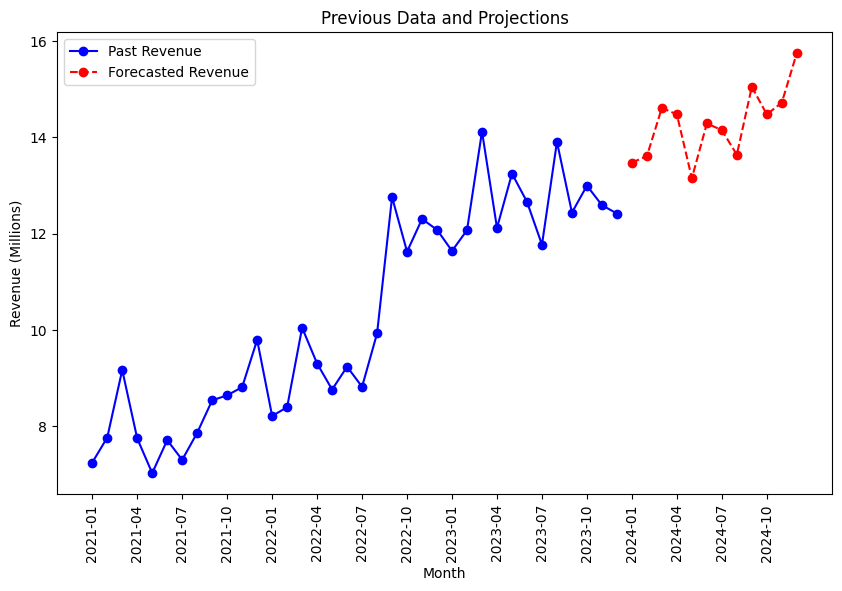

In [185]:
plt.figure(figsize=(10, 6))

# Adjust the data by dividing by 1 million to convert to millions
past_revenue = output_data.sum().values[0:-NUMBER_OF_MONTHS] / 1e6
forecasted_revenue = output_data.sum().values[-NUMBER_OF_MONTHS:] / 1e6

# Plotting the past revenue
plt.plot(output_data.columns[0:-NUMBER_OF_MONTHS], past_revenue, color='blue', marker='o', linestyle='-', label='Past Revenue')
# Plotting the forecasted revenue
plt.plot(output_data.columns[-NUMBER_OF_MONTHS:], forecasted_revenue, color='red', marker='o', linestyle='--', label='Forecasted Revenue')

plt.title('Previous Data and Projections')
plt.xlabel('Month')
plt.ylabel('Revenue (Millions)')
plt.xticks(output_data.columns[0::3], rotation=90)  # Adjust x-axis ticks

# Adding the legend to the plot
plt.legend()

# Show the plot
plt.show()

# Find Residuals